# Deep learning for timeseries

## A temperature-forecasting example

In [6]:
from tensorflow import keras

In [7]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-04-19 21:05:54--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.43.120, 3.5.0.120, 54.231.137.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.43.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  13.8MB/s    in 0.9s    

2023-04-19 21:05:55 (13.8 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [8]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [9]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

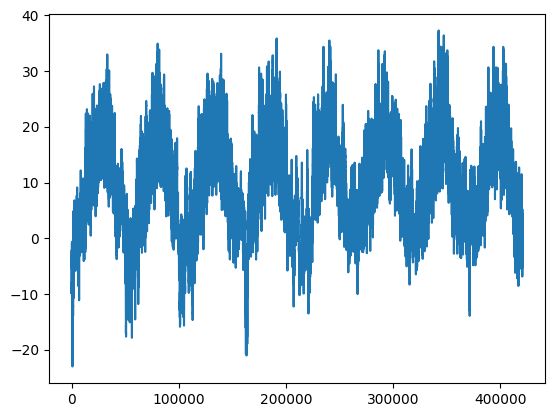

In [10]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

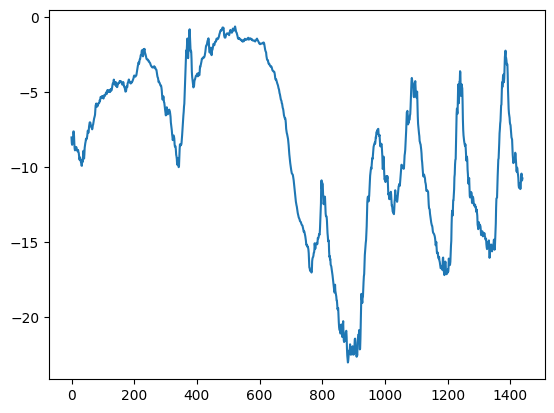

In [11]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [12]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [13]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [14]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [15]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256 

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [16]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [17]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 51ms/step - loss: 12.1851 - mae: 2.6967 - val_loss: 11.0382 - val_mae: 2.6185
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 8.8171 - mae: 2.3280 - val_loss: 10.9303 - val_mae: 2.6121
Epoch 3/10
819/819 [==============================] - 50s 61ms/step - loss: 8.0684 - mae: 2.2349 - val_loss: 10.4984 - val_mae: 2.5515
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 7.5571 - mae: 2.1655 - val_loss: 10.8642 - val_mae: 2.5853
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 7.2146 - mae: 2.1168 - val_loss: 11.2038 - val_mae: 2.6422
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 6.9993 - mae: 2.0849 - val_loss: 10.9116 - val_mae: 2.5956
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 6.8384 - mae: 2.0612 - val_loss: 12.6309 - val_mae: 2.8158
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

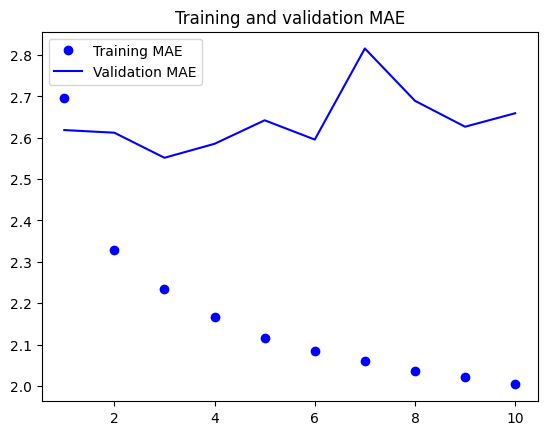

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 52ms/step - loss: 24.0157 - mae: 3.8352 - val_loss: 16.7823 - val_mae: 3.1950
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 16.0996 - mae: 3.1737 - val_loss: 14.9803 - val_mae: 3.0327
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 14.0442 - mae: 2.9603 - val_loss: 17.1244 - val_mae: 3.2994
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 12.9221 - mae: 2.8399 - val_loss: 13.7665 - val_mae: 2.8938
Epoch 5/10
819/819 [==============================] - 51s 61ms/step - loss: 12.2806 - mae: 2.7678 - val_loss: 14.1320 - val_mae: 2.9248
Epoch 6/10
819/819 [==============================] - 42s 52ms/step - loss: 11.7550 - mae: 2.7059 - val_loss: 15.3292 - val_mae: 3.0660
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 11.3436 - mae: 2.6583 - val_loss: 15.8468 - val_mae: 3.1629
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 56ms/step - loss: 41.7430 - mae: 4.6942 - val_loss: 12.7600 - val_mae: 2.7229
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 10.9477 - mae: 2.5732 - val_loss: 10.2090 - val_mae: 2.5017
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 10.0440 - mae: 2.4750 - val_loss: 9.9886 - val_mae: 2.4696
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 9.5458 - mae: 2.4094 - val_loss: 10.0213 - val_mae: 2.4689
Epoch 5/10
819/819 [==============================] - 45s 54ms/step - loss: 9.2557 - mae: 2.3673 - val_loss: 9.9628 - val_mae: 2.4666
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 8.9867 - mae: 2.3302 - val_loss: 9.9981 - val_mae: 2.4688
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 8.8305 - mae: 2.3065 - val_loss: 9.9439 - val_mae: 2.4640
Epoch 8/10
819/819 [==============================] - 46

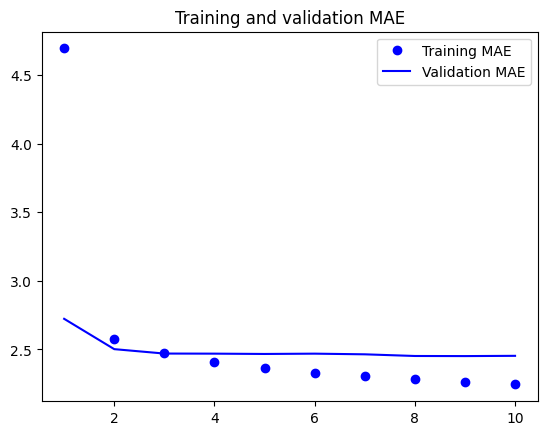

In [22]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

|Comparison|Dense Layer| CNN| RNN|
|:----:|:----:|:----:|:----:|
|Accuracy (Test mae)|2.67|3.02|2.65